### Import Librarires And Dataset

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#some settings to show data
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

target_url = ("http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data")
# target_url = "datasets/abalone.data" # if you work local dataset, more fast than a link
abalone_df = pd.read_csv(target_url)
headers = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
abalone_df.columns = headers

### Analyze the Data

In [2]:
abalone_df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


In [3]:
abalone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4176 entries, 0 to 4175
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4176 non-null   object 
 1   Length          4176 non-null   float64
 2   Diameter        4176 non-null   float64
 3   Height          4176 non-null   float64
 4   Whole weight    4176 non-null   float64
 5   Shucked weight  4176 non-null   float64
 6   Viscera weight  4176 non-null   float64
 7   Shell weight    4176 non-null   float64
 8   Rings           4176 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


**Get target value**

In [4]:
# If you want the target values to be numeric rather than categorical, actually if you want to regression, you can comment this cell
for index in abalone_df.index:
    row = abalone_df.loc[index]
    if row["Rings"] <= 8:
        abalone_df.loc[index, 'Rings'] = 'Young'
    elif row["Rings"] >= 11:
        abalone_df.loc[index, 'Rings'] = 'Old'
    elif row["Rings"] >=9 & row["Rings"] <= 10:
        abalone_df.loc[index, 'Rings'] = 'Medium'

### Implementation of Decision Tree Modeling Function:

In [5]:
def is_numeric_value(x):
    return type(x) == int or type(x) == float

In [6]:
class MyQuestioner:
    def __init__(self, column, value):
        self.column = column
        self.value = value

    def __repr__(self):
        status = "=="
        if is_numeric_value(self.value):
            status = ">="
        return f"Is {headers[self.column]} {status} {self.value}"

    def compare(self, compared):
        val = compared[self.column]
        if is_numeric_value(val):
            return val >= self.value
        else:
            return val == self.value

In [7]:
def partitioner(rows, my_question):
    true_rows, false_rows = [], []
    for row in rows:
        if my_question.compare(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows

In [8]:
def class_counts(rows):
    counts = {}  # a dictionary -> { label: count }
    for row in rows:
        label = row[-1]  # in our dataset format, the label is the last column, so -1
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

In [9]:
def gini_impurity(rows):  # There are some ways like entropy, but I use gini impurity : 
    #  https://medium.com/machine-learning-t%C3%BCrkiye/karar-agaclari-algoritmasi-b823c23997d0#:~:text=Gini%20impurity%20nedir,%C3%B6l%C3%A7mek%20i%C3%A7in%20kullan%C4%B1labilir.

    impurity_value = 1
    counts = class_counts(rows)

    for label in counts:
        probability_of_label = counts[label] / float(len(rows))
        impurity_value -= probability_of_label ** 2

    return impurity_value

In [10]:
def information_gain(left, right, current_uncertainty):
    # Information Gain: The uncertainty of the starting node, minus the weighted impurity of two child nodes.

    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - (1 - p) * gini_impurity(right) - p * gini_impurity(left)

In [11]:
def find_the_best_split(rows):
    best_gain = 0  # best information gain
    best_question = None
    n_features = len(rows[0]) - 1  # column numbers
    current_uncertainty = gini_impurity(rows)

    for col in range(n_features):  # for each feature
        values = set([row[col] for row in rows])  # unique values in the column

        for val in values:  # for each value
            question = MyQuestioner(col, val)
            true_rows, false_rows = partitioner(rows, question)  # try partitioner

            if len(true_rows) == 0 or len(false_rows) == 0:  # if there is no dataset, skip
                continue

            gain = information_gain(true_rows, false_rows, current_uncertainty)

            if gain > best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

In [12]:
class Leaf:  # Leaf node is last of three, it has a value, has not any tree
    def __init__(self, rows):
        self.predictions = class_counts(rows)

In [13]:
class DecisionNode:  # A Decision Node has two branch true or false
    def __init__(self, question, true_branch, false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

In [14]:
 def predict_all(x, tree, options):
    preditions = []

    for row in x:
        cl = classify(row, tree)
        preditions.append(max(cl, key=cl.get))

    # also I can write above code like this; preditions = [max(classify(row, tree), key=classify(row, tree).get) for row in X]
    #   but for loop like above is more clear and understandable
    return preditions

In [15]:
def predict_one(counts):
    predicted_val = max(counts, key=counts.get)
    return predicted_val

In [16]:
def show_my_tree(node, space=""):
    if isinstance(node, Leaf):
        print(space + "Predict", predict_one(node.predictions)) # To write in line as a same indent
        return

    print(space + str(node.question)) # Ask question

    print(space + '--> False/Left:')
    show_my_tree(node.false_branch, space + "  ")

    print(space + '--> True/Right:')
    show_my_tree(node.true_branch, space + "  ")

In [17]:
def classify(row, node):
    if isinstance(node, Leaf):
        return node.predictions

    if node.question.compare(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

In [18]:
def print_leaf(counts):
    total = sum(counts.values()) * 1.0
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs

In [19]:
def builder_without_pruning(rows, attribute_types):
    gain, question = find_the_best_split(rows)

    if gain == 0:
        return Leaf(rows)

    true_rows, false_rows = partitioner(rows, question)
    true_branch = builder_without_pruning(true_rows, attribute_types)  # Recursive call without pruning
    false_branch = builder_without_pruning(false_rows, attribute_types)  # Recursive call without pruning
    
    return DecisionNode(question, true_branch, false_branch)

In [20]:
def builder_with_pruning(rows, max_depth, attribute_types, curr_depth=0):
    if curr_depth <= max_depth:
        gain, question = find_the_best_split(rows)

        if gain == 0:
            return Leaf(rows)

        true_rows, false_rows = partitioner(rows, question)
        true_branch = builder_with_pruning(true_rows, max_depth, attribute_types, curr_depth + 1)  # Recursive call
        false_branch = builder_with_pruning(false_rows, max_depth, attribute_types, curr_depth + 1)  # Recursive call
        
        return DecisionNode(question, true_branch, false_branch)

    return Leaf(rows)

In [21]:
def build_dt(X, y, attribute_types, options):
    rows = np.concatenate((X, y), axis=1).tolist()
    
    if options["pruning"]:
        return builder_with_pruning(rows, options["max_depth"], attribute_types)    
    elif not options["pruning"]:
        return builder_without_pruning(rows, attribute_types)

In [22]:
def predict_dt(dt, X, options):
    return np.array(predict_all(X, dt, options))

In [23]:
X = abalone_df.iloc[:, :-1].values
y = abalone_df.iloc[:, -1].values.reshape(-1, 1)

options = {"max_depth": 5, "pruning": False}
attribute_types = abalone_df.dtypes.apply(str).tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=41)

### Show Tree

In [24]:
my_tree = build_dt(X_train, y_train, attribute_types, options)
y_pred = predict_dt(my_tree, X_test, options)
show_my_tree(my_tree)

Is Shell weight >= 0.1515
--> False/Left:
  Is Sex == I
  --> False/Left:
    Is Shell weight >= 0.0485
    --> False/Left:
      Is Length >= 0.31
      --> False/Left:
        Predict Young
      --> True/Right:
        Is Height >= 0.075
        --> False/Left:
          Predict Old
        --> True/Right:
          Is Height >= 0.085
          --> False/Left:
            Is Length >= 0.33
            --> False/Left:
              Predict Medium
            --> True/Right:
              Predict Young
          --> True/Right:
            Predict Young
    --> True/Right:
      Is Shucked weight >= 0.234
      --> False/Left:
        Is Diameter >= 0.28
        --> False/Left:
          Is Whole weight >= 0.217
          --> False/Left:
            Is Length >= 0.355
            --> False/Left:
              Is Shell weight >= 0.063
              --> False/Left:
                Is Shucked weight >= 0.0735
                --> False/Left:
                  Is Height >= 0.09
           

### Find Confusion Matrices Without K-fold Cross Validation

In [25]:
print(f"Accuarcy score: {accuracy_score(y_test, y_pred)}")
confusion_matrix(y_test, y_pred)

Accuarcy score: 0.5574162679425837


array([[117,  77,  66],
       [110, 165,  30],
       [ 58,  29, 184]])

### Find Confusion Matrices With K-fold Cross Validation

### Note: My Implementation of Decision Tree Testing Function Is IN cross_val() FUNCTION where line number 14 (y_pred_fold)

In [26]:
kf = KFold(n_splits=6, shuffle=True, random_state=42)
# Lists to store accuracy scores & confusion_matrices for each fold

def cross_val(options):
    # Perform k-fold cross-validation via kf.split(X_train), this function give me an indexes subset of X_train
    accuracy_scores = []
    confusion_matrices = []
    
    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
    
        my_tree = build_dt(X_train_fold, y_train_fold, attribute_types, options)
        y_pred_fold = predict_dt(my_tree, X_val_fold, options)
    
        # Calculate accuracy and confusion_matrix for current fold
        accuracy = accuracy_score(y_val_fold, y_pred_fold)
        cm = confusion_matrix(y_val_fold, y_pred_fold)
    
        # Store accuracy score and confusion_matrix
        accuracy_scores.append(accuracy)
        confusion_matrices.append(cm)
    
    return accuracy_scores, confusion_matrices

### Results of k-fold cross validation:

In [27]:
def plot_confusion_matrix_accuracy_score(accuracy_scores, confusion_matrices):
    for i, score in enumerate(accuracy_scores):
        plt.figure(figsize=(3, 3))
        sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cmap='Greens')
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        i+=1
        plt.xlabel(f'{i}. Fold cross validation Score: {score:.3f}')
        plt.plot()
        print(confusion_matrices)
        print(f'{i}. cross validation score: {score:.3f}')
        
    plt.show()
    
    # Calculate average accuracy across all folds
    avg_accuracy = np.mean(accuracy_scores)
    print(f"Average accuracy: {avg_accuracy}")

### Without pruning

[array([[ 93,  63,  53],
       [ 91, 137,  21],
       [ 50,  24, 164]]), array([[ 94,  88,  45],
       [ 75, 129,  20],
       [ 57,  23, 165]]), array([[ 82,  74,  48],
       [ 76, 149,  22],
       [ 55,  24, 166]]), array([[ 93,  71,  60],
       [ 86, 147,  21],
       [ 37,  25, 156]]), array([[ 88,  84,  56],
       [ 72, 139,  20],
       [ 48,  18, 171]]), array([[ 97,  83,  51],
       [ 77, 140,  24],
       [ 54,  21, 149]])]
1. cross validation score: 0.566
[array([[ 93,  63,  53],
       [ 91, 137,  21],
       [ 50,  24, 164]]), array([[ 94,  88,  45],
       [ 75, 129,  20],
       [ 57,  23, 165]]), array([[ 82,  74,  48],
       [ 76, 149,  22],
       [ 55,  24, 166]]), array([[ 93,  71,  60],
       [ 86, 147,  21],
       [ 37,  25, 156]]), array([[ 88,  84,  56],
       [ 72, 139,  20],
       [ 48,  18, 171]]), array([[ 97,  83,  51],
       [ 77, 140,  24],
       [ 54,  21, 149]])]
2. cross validation score: 0.557
[array([[ 93,  63,  53],
       [ 91, 137,  

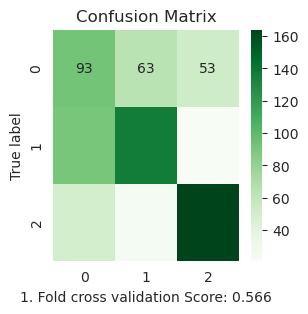

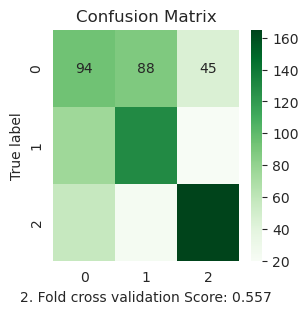

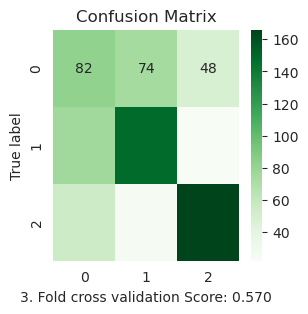

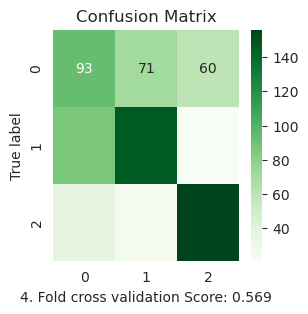

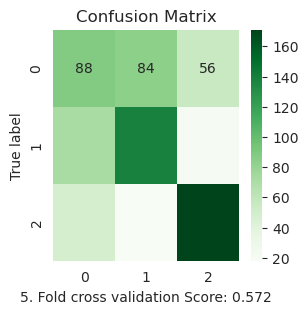

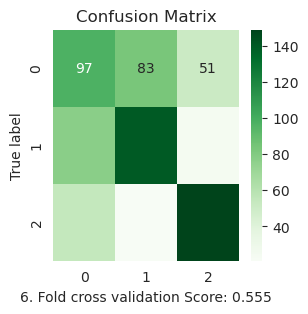

Average accuracy: 0.5648946360153257


In [28]:
accuracy_scores, confusion_matrices = cross_val(options)
plot_confusion_matrix_accuracy_score(accuracy_scores, confusion_matrices)

### With pruning

[array([[114,  59,  36],
       [ 69, 171,   9],
       [ 58,  18, 162]]), array([[122,  73,  32],
       [ 65, 144,  15],
       [ 52,  15, 178]]), array([[ 93,  70,  41],
       [ 75, 153,  19],
       [ 49,  16, 180]]), array([[ 98,  60,  66],
       [ 74, 167,  13],
       [ 40,  12, 166]]), array([[109,  58,  61],
       [ 73, 138,  20],
       [ 30,  10, 197]]), array([[135,  60,  36],
       [ 87, 140,  14],
       [ 59,  15, 150]])]
1. cross validation score: 0.642
[array([[114,  59,  36],
       [ 69, 171,   9],
       [ 58,  18, 162]]), array([[122,  73,  32],
       [ 65, 144,  15],
       [ 52,  15, 178]]), array([[ 93,  70,  41],
       [ 75, 153,  19],
       [ 49,  16, 180]]), array([[ 98,  60,  66],
       [ 74, 167,  13],
       [ 40,  12, 166]]), array([[109,  58,  61],
       [ 73, 138,  20],
       [ 30,  10, 197]]), array([[135,  60,  36],
       [ 87, 140,  14],
       [ 59,  15, 150]])]
2. cross validation score: 0.638
[array([[114,  59,  36],
       [ 69, 171,  

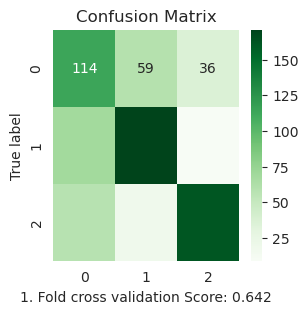

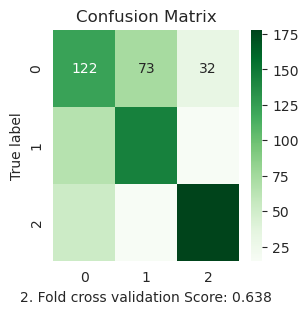

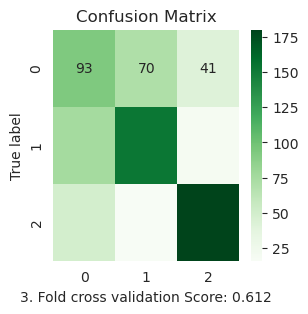

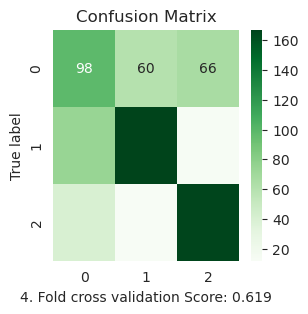

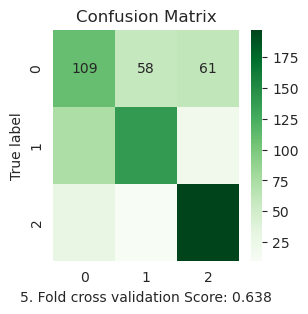

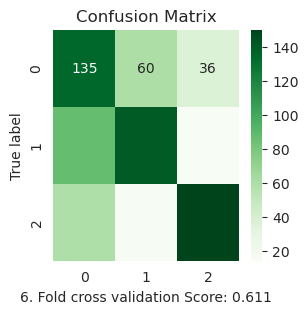

Average accuracy: 0.626676245210728


In [29]:
options["pruning"] = True
accuracy_scores, confusion_matrices = cross_val(options)
plot_confusion_matrix_accuracy_score(accuracy_scores, confusion_matrices)

### As you can see 
*Without cross-validation without pruning 
-> Accuarcy score:*  **~ 0.55**

*With cross-validation without pruning 
-> Accuarcy score:*  **~ 0.57**

*With cross-validation with pruning 
-> Accuarcy score:*  **~ 0.63**

### Let's Go Random Forest

In [30]:
from collections import Counter

def build_rdf(X, y, attribute_types, N, options):
    trees = []
    for _ in range(N):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        X_sample = X[idxs]
        y_sample = y[idxs]
        tree = build_dt(X_sample, y_sample, attribute_types, options)
        trees.append(tree)
    return trees



In [31]:
def predict_rdf(rdf, X, options):
    predictions = np.array([predict_dt(tree, X, options) for tree in rdf])
    tree_preds = np.swapaxes(predictions, 0, 1)
    predictions = np.array([most_frequently_label(pred) for pred in tree_preds])
    return predictions 

def most_frequently_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

In [32]:
def cross_val_rdf(options, N):
    # Perform k-fold cross-validation via kf.split(X_train), this function give me an index subset of X_train
    accuracy_scores = []
    confusion_matrices = []

    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
    
        rdf = build_rdf(X_train_fold, y_train_fold, attribute_types, N, options)
        y_pred_rdf_fold = predict_rdf(rdf, X_val_fold, options)
    
        # Calculate accuracy and confusion_matrix for current fold
        accuracy = accuracy_score(y_val_fold, y_pred_rdf_fold)
        cm = confusion_matrix(y_val_fold, y_pred_rdf_fold)
    
        # Store accuracy score and confusion_matrix
        accuracy_scores.append(accuracy)
        confusion_matrices.append(cm)
    
    return accuracy_scores, confusion_matrices

[array([[100,  70,  39],
       [ 64, 170,  15],
       [ 51,  19, 168]]), array([[108,  87,  32],
       [ 55, 153,  16],
       [ 44,  22, 179]]), array([[ 92,  70,  42],
       [ 77, 141,  29],
       [ 47,  17, 181]]), array([[143,  58,  23],
       [ 89, 162,   3],
       [ 84,   4, 130]]), array([[120,  77,  31],
       [ 82, 139,  10],
       [ 45,  18, 174]]), array([[153,  49,  29],
       [109, 124,   8],
       [ 63,  12, 149]])]
1. cross validation score: 0.629
[array([[100,  70,  39],
       [ 64, 170,  15],
       [ 51,  19, 168]]), array([[108,  87,  32],
       [ 55, 153,  16],
       [ 44,  22, 179]]), array([[ 92,  70,  42],
       [ 77, 141,  29],
       [ 47,  17, 181]]), array([[143,  58,  23],
       [ 89, 162,   3],
       [ 84,   4, 130]]), array([[120,  77,  31],
       [ 82, 139,  10],
       [ 45,  18, 174]]), array([[153,  49,  29],
       [109, 124,   8],
       [ 63,  12, 149]])]
2. cross validation score: 0.632
[array([[100,  70,  39],
       [ 64, 170,  

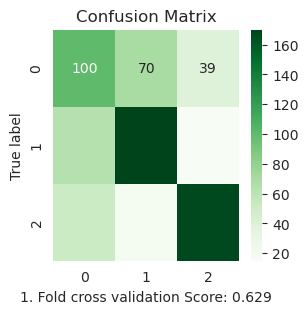

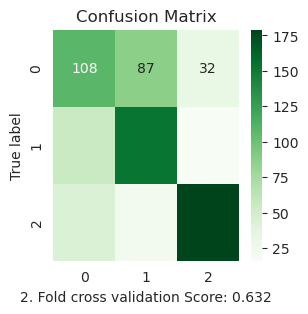

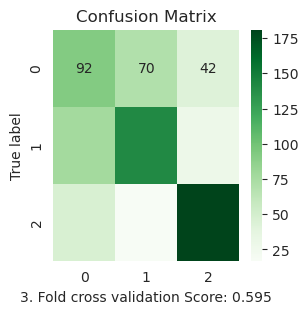

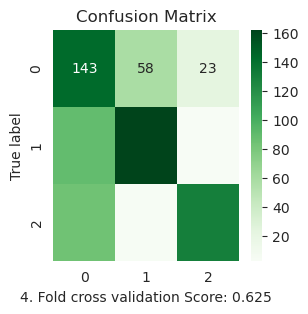

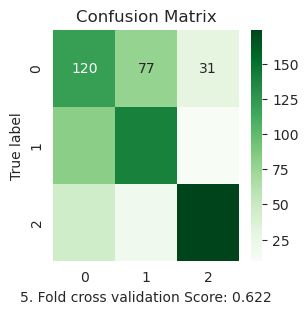

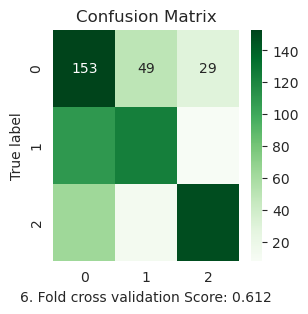

Average accuracy: 0.6192528735632185


In [33]:
accuracy_scores, confusion_matrices = cross_val_rdf(options, 2)
plot_confusion_matrix_accuracy_score(accuracy_scores, confusion_matrices)

### As you can see 
*With Random Forest and N = 2
-> Accuarcy score:*  **~ 0.61**
 
Actually, the score is too good, because I set only N = 2 for a performance problem, even though this operation took approximately 70 seconds. So if you test N = 5 or N = 10 paramater, it will take larger processing time between 500 or 1000 seconds.

# PS 
## When I drew the confusion_matrices on my own computer, although the information in the first line was written as TrueFalse / FalseNegative ..., the other lines did not appear correctly. Additionally, I printed the confusion_matrices and ran the notebook in colab, the confusion_matrices were drawn properly, I think there may be some problems with my computer, if you want to see it, google colab. I ran it and placed the outputs in an additional notebook.

# Resources that I have used
highly recommend 1
**https://github.com/AssemblyAI-Examples/Machine-Learning-From-Scratch/blob/main/05%20Random%20Forests/RandomForest.py** 

highly recommend 2
**https://github.com/java-byte/ML-Decision-Tree/blob/master/Decision_tree.ipynb**  

highly recommend 3
**https://github.com/Suji04/ML_from_Scratch/blob/master/decision%20tree%20classification.ipynb** 

https://github.com/sthite175/AbaloneAge-Predictor/blob/main/abalone-age-prediction-project.ipynb
https://github.com/huiminren/AbalonesAgeClassification/blob/master/AbalonesAgeClassification.ipynb
https://towardsdatascience.com/decision-tree-in-machine-learning-e380942a4c96